# Load the data and upload to HF

In [1]:
from datasets import Dataset
from datasets import load_dataset
from glob import glob
import pandas as pd
import numpy as np

In [2]:
configuration = glob("*/*/*")
energy = []
latency_stats = []
throughput = []
for c in configuration:
    pwr = pd.read_csv(c+"/pwr.csv")
    t = pd.to_datetime(pwr['timestamp'], format='%Y/%m/%d %H:%M:%S.%f')
    δt = (np.diff(t)/1e9).astype("float")
    P = np.array(pwr[' power.draw [W]'][:-1].str.replace(' W', '')).astype(float)
    energy.append(np.sum(δt*P))

    tput = pd.read_csv(c+"/tput.csv").to_numpy()[0][2:4]
    p0 = pd.read_csv(c+"/total_p0.csv").to_numpy()[0][2:4]
    p50 = pd.read_csv(c+"/total_p50.csv").to_numpy()[0][2:4]
    p90 = pd.read_csv(c+"/total_p90.csv").to_numpy()[0][2:4]
    p100 = pd.read_csv(c+"/total_p100.csv").to_numpy()[0][2:4]
    latency = np.vstack([p0,p50,p90,p100])

    if len(tput) == 1:
        tput = np.hstack([tput,np.nan])
        latency = np.hstack([latency,[[np.nan],[np.nan],[np.nan],[np.nan]]])

    latency_stats.append(latency)
    throughput.append(tput)

In [3]:
dataset = Dataset.from_dict({
    'configuration': configuration,
    'energy': energy,
    'latency_stats': latency_stats,
    'throughput': throughput,
})
dataset.push_to_hub("danjacobellis/model_pairs",split='train')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/danjacobellis/model_pairs/commit/81f72b7944e1fded039d8215ae632a02b3da5282', commit_message='Upload dataset', commit_description='', oid='81f72b7944e1fded039d8215ae632a02b3da5282', pr_url=None, pr_revision=None, pr_num=None)

# Plot

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt

In [2]:
dataset = load_dataset("danjacobellis/model_pairs",split='train')

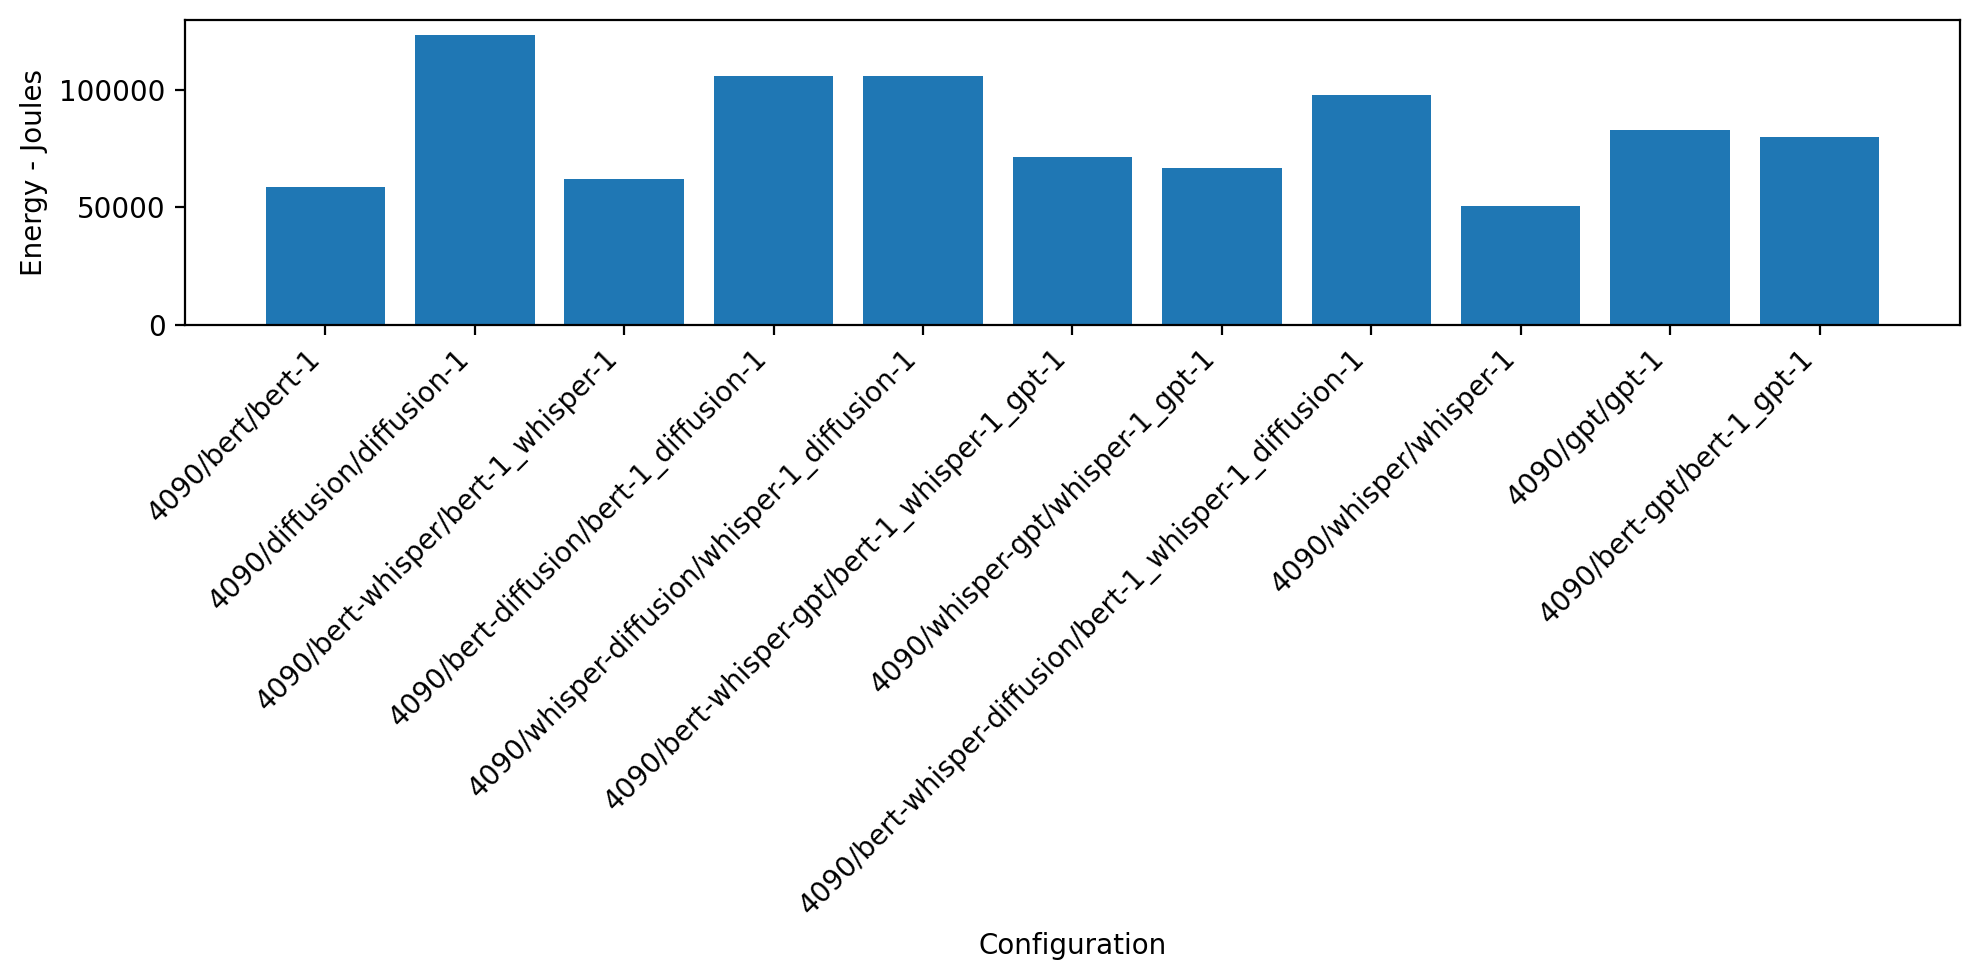

In [3]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
ax.bar(dataset['configuration'][0:11], dataset['energy'][0:11])
ax.set_ylabel('Energy - Joules')
ax.set_xlabel('Configuration')
plt.xticks(rotation=45, ha='right')  # 'ha' is the same as horizontalalignment
plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
plt.show()

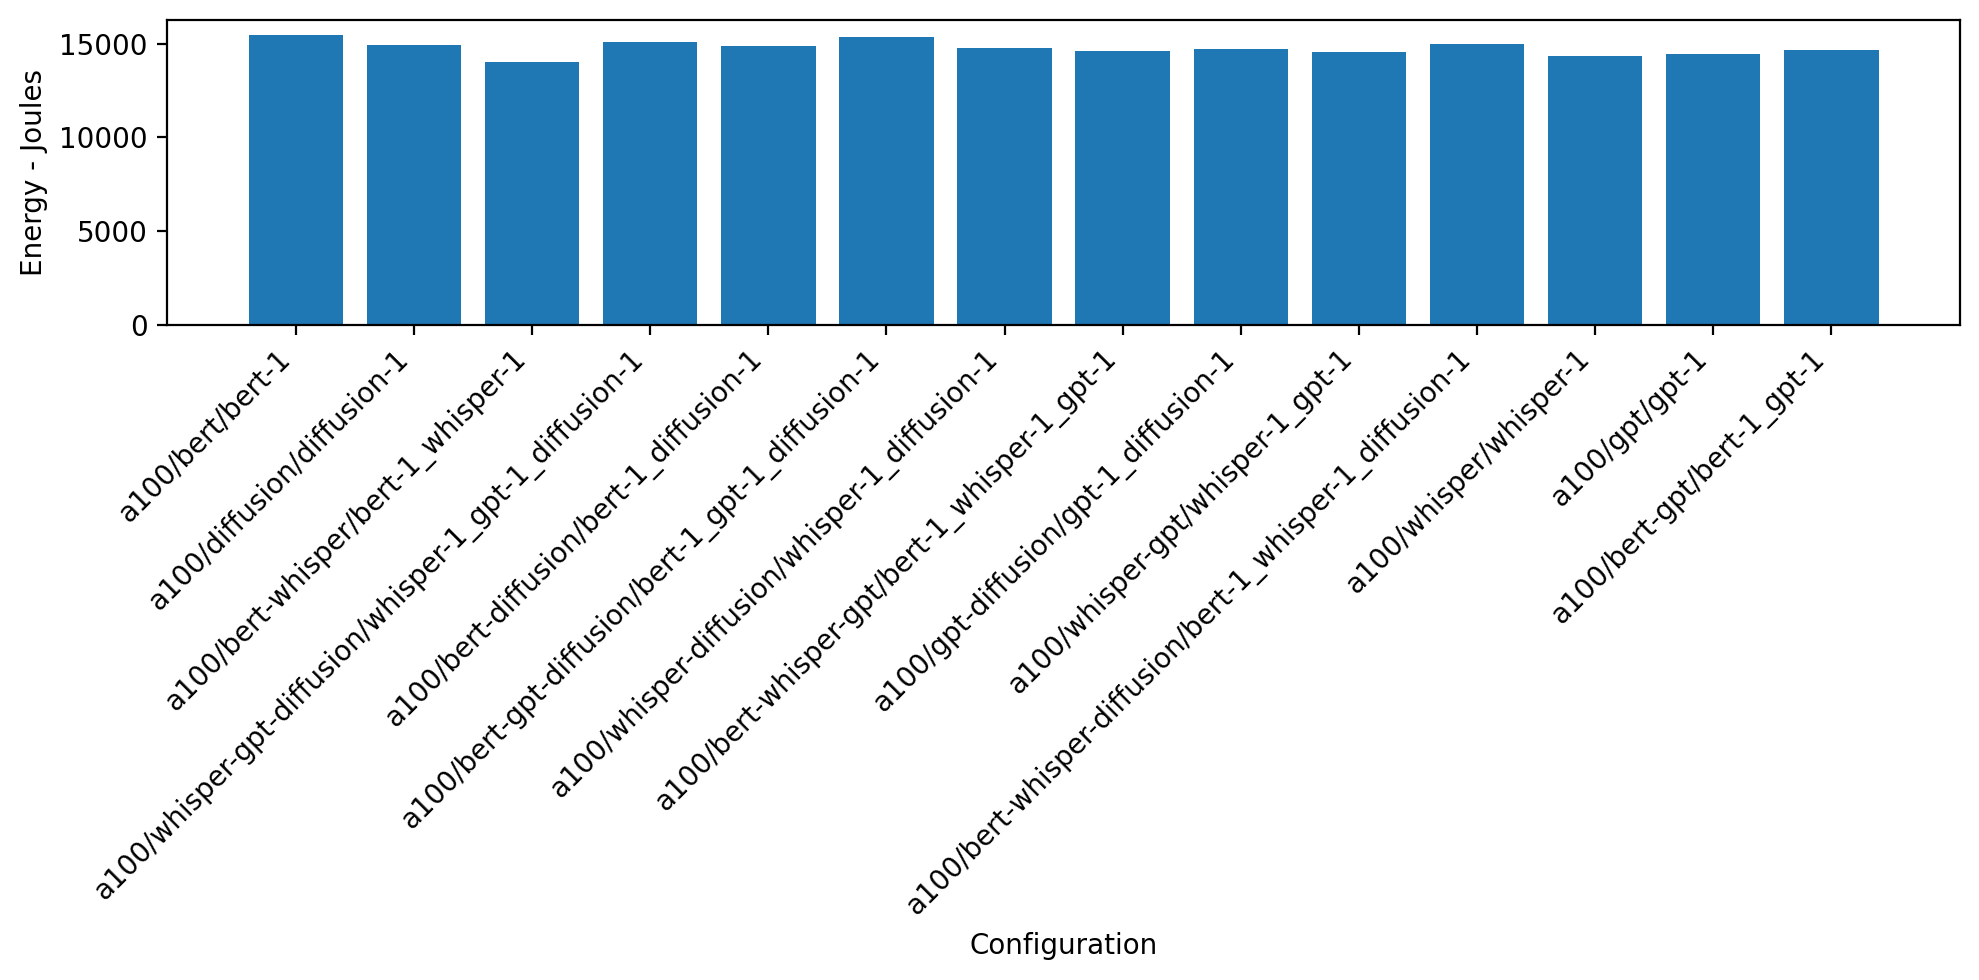

In [4]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
ax.bar(dataset['configuration'][11:], dataset['energy'][11:])
ax.set_ylabel('Energy - Joules')
ax.set_xlabel('Configuration')
plt.xticks(rotation=45, ha='right')  # 'ha' is the same as horizontalalignment
plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
plt.show()